# Introducing Llama 3.2 vision models on Amazon Bedrock

![llama 3.2 vision](./img/llama32vision.jpeg)

The Llama 3.2 collection of models are now available in Amazon Bedrock. Llama 3.2 represents Meta’s latest advancement in large language models (LLMs). Llama 3.2 models are offered in various sizes, from small and medium-sized multimodal models, 11B and 90B parameter models, capable of sophisticated reasoning tasks including multimodal support for high resolution images to lightweight text-only 1B and 3B parameter models suitable for edge devices. Llama 3.2 is the first Llama model to support vision tasks, with a new model architecture that integrates image encoder representations into the language model.

In addition to the existing text capable Llama 3.1 8B, 70B, and 405B models, Llama 3.2 supports multimodal use cases. You can now use four new Llama 3.2 models — 90B, 11B, 3B, and 1B — from Meta in Amazon Bedrock to unlock the next generation of AI possibilities. With a focus on responsible innovation and system-level safety, Llama 3.2 models help you build and deploy cutting-edge generative AI models and applications, leveraging Llama in Amazon Bedrock to ignite new innovations like image reasoning and are also more accessible for on edge applications. The new models are also designed to be more efficient for AI workloads, with reduced latency and improved performance, making them suitable for a wide range of applications.

This notebook provides you with three examples of how to leverage multi-modality (text, vision) of models in different problem areas. It showcases, how to use boto3 and Bedrock's converse API for seamless and easy access of these models.

In [1]:
!pip install boto3==1.35.18

In [2]:
import boto3
from PIL import Image

In [3]:
boto3.__version__

'1.35.18'

# Setup

We start by setting up the Bedrock client for us-west-2 region. Then, we specify the model name. Note, that Meta Llama 3.2 models are avaliable through cross-region inference only. Hence, instead of the model id we are using the cross-region inference id of a specific region. 

In [4]:
bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")
MODEL_ID = "us.meta.llama3-2-90b-instruct-v1:0"

### Function to create the messages object with text prompt and image

Since we are going to be using the messages object everytime we are going to query an image, we can write a function as follows to create the payload so that it becomes reusable.

In [5]:
def make_messages(question, image_path, inf_parameters=None):
    try:
        with open(image_path, "rb") as image_file:
            image_bytes = image_file.read()
        image_data = image_bytes
        img = Image.open(image_path)
        imgformat = img.format
        #print(img.format)
        image_media_type = imgformat.lower()#'png'  # Adjust if using a different image format
    except FileNotFoundError:
        print(f"Image file not found at {image_path}")
        image_data = None
        image_media_type = None
    

    messages = [            
            {
                "role": "user",
                "content": [
                {                        
                    "text": question
                },
                {
                    "image": {
                        "format": image_media_type,
                        "source": {
                            "bytes": image_data
                        }
                    }
                }
                ]
            }
        ]

    return messages

# Chart Q&A 

The first use case is a very common one in today's office world: reading out data from charts or diagrams and answering questions on top of that. We are using the Bedrock converse API to place the query consisting of a text and image message assuming the user role. 

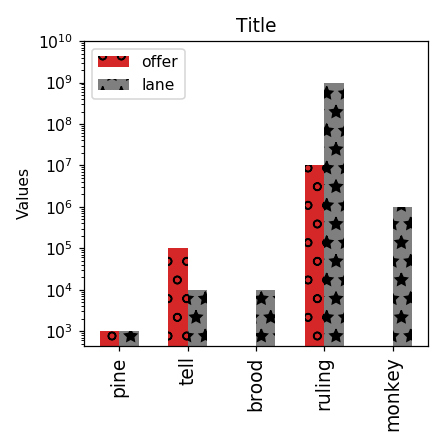

Looking at the bar plot, we can see that there are two groups of bars: 'offer' and 'lane'. Each group has five bars corresponding to the x-labels: pine, tell, brood, ruling, and monkey.

To find the word with the highest count, we need to compare the heights of the bars. The highest bar in the 'offer' group is the one corresponding to 'ruling', and the highest bar in the 'lane' group is also the one corresponding to 'ruling'.

Since the 'ruling' bar in the 'lane' group is slightly higher than the 'ruling' bar in the 'offer' group, we can conclude that the word with the highest count in the chart is 'ruling'.

**Answer:** ruling


In [6]:
# Chart Q&A
question = 'What word has the highest count in the chart?'
image_path = "img/401.png"
messages = make_messages(question, image_path)
# Display the image
image = Image.open(image_path)
image.show()
# Send the request to converse to get the response
try:
    # Invoke the SageMaker endpoint
    response = bedrock_client.converse(
        modelId=MODEL_ID, # MODEL_ID defined at the beginning
        messages=messages,
        inferenceConfig={
        "maxTokens": 2048,
        "temperature": 0,
        "topP": .1
        },        
    )
    
    # Read the response 
    print(response['output']['message']['content'][0]['text'])

except Exception as e:
    print(f"An error occurred while invoking the endpoint: {str(e)}")

# Understanding and reasoning with screenshot of xlsx file

The second use case showcases how easy it is to integrate more sophisticated documents like Excel or Powerpoint files. While models can't natively process such file types and document parsing of such complex documents usually provides poor results, feeding a screenshot of the documents into a multi-modal model has proven to be very powerful for solving tasks over those documents. Again, we are using the converse API to figure out what is contained in the yellow box. 

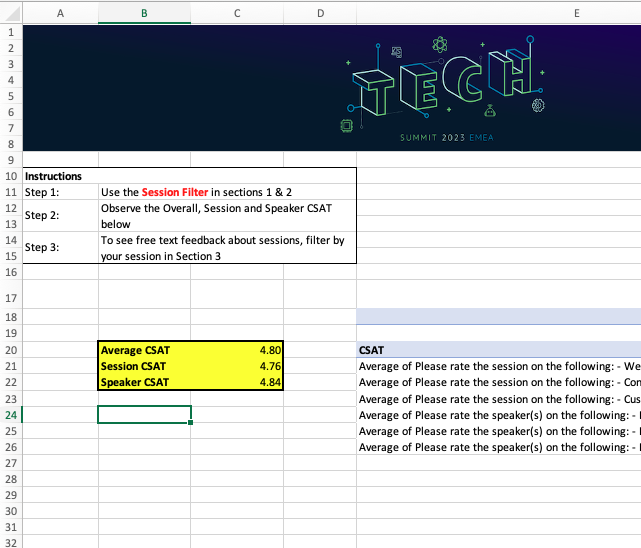

The yellow box contains the average CSAT scores for the session and speaker, which are 4.80 and 4.76, respectively. The speaker CSAT score is 4.84.


In [7]:
# Screenshot Q&A
question = 'What is in the yellow box?'
image_path = "img/screenshot.png"
messages = make_messages(question, image_path)
# Display the image
image = Image.open(image_path)
image.show()
# Send the request to converse to get the response
try:
    # Invoke the SageMaker endpoint
    response = bedrock_client.converse(
        modelId=MODEL_ID, # MODEL_ID defined at the beginning
        messages=messages,
        inferenceConfig={
        "maxTokens": 2048,
        "temperature": 0,
        "topP": .1
        },        
    )
    
    # Read the response 
    print(response['output']['message']['content'][0]['text'])

except Exception as e:
    print(f"An error occurred while invoking the endpoint: {str(e)}")

# Advanced mathematical reasoning (MathVista example) 

Finally, we are looking into an advanced mathematical reasoning example sourced out of the MathVista benchmarking dataset. We want the model to figure out the degree of ∠CAB based on some input parameters. The answer is in multiple-choice format. This task goes way beyond multi-modal perception and understanding and requires complex reasoning. Again, we are using the Bedrock converse API for placing this task. 
Hint: the right answer is (C) 64°.

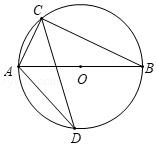

To find the degree of ∠CAB, we can use the properties of a circle and its angles. Since AB is the diameter of ⊙O, it divides the circle into two semicircles. The angle subtended by a diameter at the circumference is always 90 degrees.

Given that ∠ADC = 26.0 degrees, we know that this angle is inscribed in one of the semicircles formed by diameter AB. The angle subtended by a chord at the center of the circle is twice the angle subtended by the same chord at any point on the circumference.

Let's denote the center of the circle as O. Since CD is a chord, ∠COD (the angle subtended by CD at the center) is twice the angle subtended by CD at any point on the circumference, which in this case is ∠ADC.

Therefore, ∠COD = 2 * ∠ADC = 2 * 26.0 = 52.0 degrees.

Now, since AB is the diameter, ∠AOB (the angle subtended by AB at the center) is 180 degrees because it forms a straight line. We are interested in finding ∠CAB, which is part of the larger angle ∠COB.

We can find ∠COB by subtracting ∠CO

In [8]:
# Math vision Q&A
question = 'Please answer the question and provide the correct option letter, e.g., A, B, C, D, at the end. Think very carefully in a step-by-step manner. Reflect on your approach, and change your answer and approach based on your reflection. Question: As shown in the figure, AB is the diameter of ⊙O, CD is the chord of ⊙O, ∠ADC = 26.0, then the degree of ∠CAB is () Choices: (A) 26° (B) 74° (C) 64° (D) 54°'
image_path = "img/geometry.png"
messages = make_messages(question, image_path)
# Display the image
image = Image.open(image_path)
image.show()
# Send the request to converse to get the response
try:
    # Invoke the SageMaker endpoint
    response = bedrock_client.converse(
        modelId=MODEL_ID, # MODEL_ID defined at the beginning
        messages=messages,
        inferenceConfig={
        "maxTokens": 2048,
        "temperature": 0,
        "topP": .1
        },        
    )
    
    # Read the response 
    print(response['output']['message']['content'][0]['text'])

except Exception as e:
    print(f"An error occurred while invoking the endpoint: {str(e)}")

### Plot, graph, table Q&A - Amazon earnings report
In the following example, we show the ability of Llama 3.2 vision models to answer detailed reasoning questions from visual data sources. 

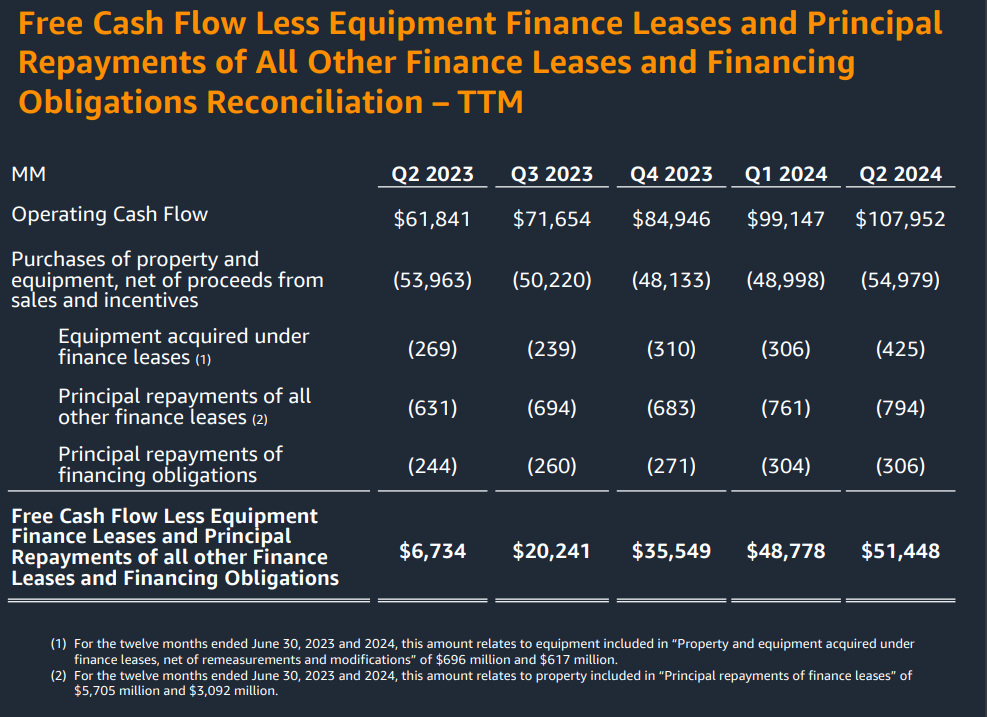

**Cash Flow Analysis**

The slide presents a 12-month cash flow analysis, comparing the last 12 months (LTM) to the trailing twelve months (TTM). The data reveals a significant increase in free cash flow, primarily driven by the acquisition of equipment under finance leases.

**Operating Cash Flow Trend**

*   The operating cash flow has remained relatively stable, with a slight increase from $61,841 in Q2 2023 to $107,952 in Q2 2024.
*   This stability is attributed to consistent sales and incentives, as well as steady purchases of property and equipment.

**Free Cash Flow Trend**

*   The free cash flow has experienced a substantial increase, rising from $6,734 in Q2 2023 to $51,448 in Q2 2024.
*   This growth is largely due to the acquisition of equipment under finance leases, which has increased from $269 in Q2 2023 to $425 in Q2 2024.

**Significant Contributor to Free Cash Flow Trend**

*   The acquisition of equipment under finance leases is the primary driver of the free cash f

In [9]:
# Amazon earnings plot questions
question = 'Can you please help me understand this slide? How are the operating and free cash flow trending the last 12 month period? What is the significant contributor to the free cash flow trend?'
#question = 'is free cash flow of $6,734 is bigger than $51,448?'
image_path = "img/slide-3.png"
messages = make_messages(question, image_path)
# Display the image
image = Image.open(image_path)
image.show()
# Send the request to converse to get the response
try:
    # Invoke the SageMaker endpoint
    response = bedrock_client.converse(
        modelId=MODEL_ID, # MODEL_ID defined at the beginning
        messages=messages,
        inferenceConfig={
        "maxTokens": 2048,
        "temperature": 0,
        "topP": .1
        },        
    )
    
    # Read the response 
    print(response['output']['message']['content'][0]['text'])

except Exception as e:
    print(f"An error occurred while invoking the endpoint: {str(e)}")

## Entity Extraction

Extracting information about products is an important use case for the retail industry. On platforms supporting third-party sellers, product images are the most available resources to gather information about the product. Therefore, accurately extracting relevant information about the product is essential for the success of the product. 

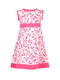

Based on the image, here is the extracted information about the product in JSON format:

```json
{
  "product_id": "DRESS001",
  "name": "Pink Floral Dress",
  "description": "A sleeveless dress with a pink floral pattern and a pink trim at the hem and waist.",
  "category": "Dresses",
  "sub_category": "Casual Dresses",
  "gender": "Female",
  "age_group": "Adult",
  "color": "White with Pink Floral Pattern",
  "size": "Not specified",
  "material": "Not specified",
  "price": "Not specified",
  "image_url": "https://example.com/product-image.jpg",
  "additional_features": [
    "Sleeveless",
    "Pink trim at hem and waist"
  ]
}
```

Please note that some information, such as the product ID, price, and material, is not visible in the image and would need to be obtained from other sources. Additionally, the size is not specified in the image, so it is left blank in the JSON.


In [10]:
# Entity extraction
question = 'Can you please extract all information about the product in the image? Think very carefully in a step-by-step manner to construct a json to organize all the information about the product. Please consider formulating the json so that the extracted information can be stored in a database for further use in a retail ecommerce application. Return the json as the output.'
image_path = "img/clothing-1.jpg"
messages = make_messages(question, image_path)
# Display the image
image = Image.open(image_path)
image.show()
# Send the request to converse to get the response
try:
    # Invoke the SageMaker endpoint
    response = bedrock_client.converse(
        modelId=MODEL_ID, # MODEL_ID defined at the beginning
        messages=messages,
        inferenceConfig={
        "maxTokens": 2048,
        "temperature": 0,
        "topP": .1
        },        
    )
    
    # Read the response 
    print(response['output']['message']['content'][0]['text'])

except Exception as e:
    print(f"An error occurred while invoking the endpoint: {str(e)}")

### Caption Generation

Caption generation is another important use case for vision models. It helps users automtatically generate image captions, image descriptions for more natural search experience and engagement experience.

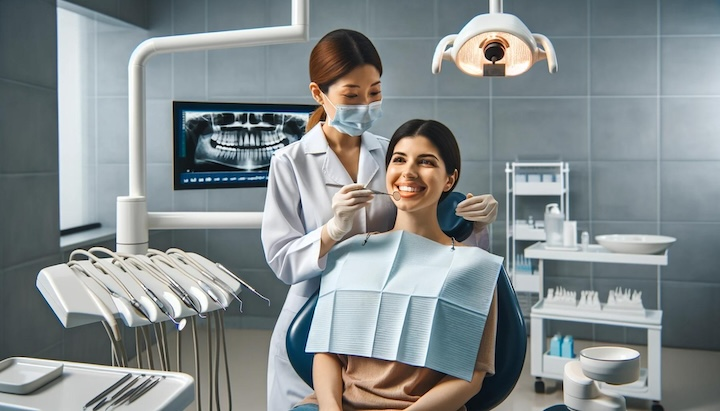

"Smile, it's a 'filling' day at the dentist's office!"


In [11]:
# Caption generation - simple caption use case
question = 'Please provide a short caption for this image. Be creative and funny but respectful. This is meant to be shared on a social network application.'
image_path = "img/synth-data-3.jpg"
messages = make_messages(question, image_path)
# Display the image
image = Image.open(image_path)
image.show()
# Send the request to converse to get the response
try:
    # Invoke the SageMaker endpoint
    response = bedrock_client.converse(
        modelId=MODEL_ID, # MODEL_ID defined at the beginning
        messages=messages,
        inferenceConfig={
        "maxTokens": 2048,
        "temperature": 0.8,
        "topP": .1
        },        
    )
    
    # Read the response 
    print(response['output']['message']['content'][0]['text'])

except Exception as e:
    print(f"An error occurred while invoking the endpoint: {str(e)}")

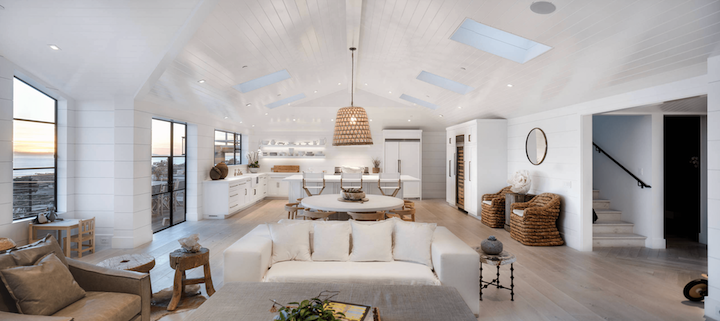

**Luxury Coastal Living at Its Finest**

**Property Type:** Single-Family Home

**Location:** [Insert Location]

**Price:** $3,500,000

**Beds:** 4

**Baths:** 3.5

**Square Footage:** 3,500 sqft

**Lot Size:** 0.25 acres

**Year Built:** 2020

**MLS Number:** [Insert MLS Number]

Welcome to this stunning coastal retreat, where luxury meets serenity. This 4-bedroom, 3.5-bathroom masterpiece boasts 3,500 square feet of meticulously designed living space, perfect for those seeking the ultimate in comfort and style.

**Key Features:**

* **Open-Concept Living:** The heart of the home features a spacious open-concept living area, complete with a gourmet kitchen, dining space, and cozy living room. Perfect for entertaining or relaxing with family and friends.
* **Gourmet Kitchen:** Equipped with high-end appliances, ample counter space, and a large center island, this kitchen is a culinary dream come true.
* **Luxurious Master Suite:** Retreat to the serene master suite, complete with a spa

In [12]:
# Caption generation - marketing listing generation style use case
question = 'You are a real estate marketing expert. Please create a listing description with the attached image of a property.'
image_path = "img/interior-3.png"
messages = make_messages(question, image_path)
# Display the image
image = Image.open(image_path)
image.show()
# Send the request to converse to get the response
try:
    # Invoke the SageMaker endpoint
    response = bedrock_client.converse(
        modelId=MODEL_ID, # MODEL_ID defined at the beginning
        messages=messages,
        inferenceConfig={
        "maxTokens": 2048,
        "temperature": 0,
        "topP": .1
        },        
    )
    
    # Read the response 
    print(response['output']['message']['content'][0]['text'])

except Exception as e:
    print(f"An error occurred while invoking the endpoint: {str(e)}")